In [1]:
import ROOT
import re
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib   # Needed for font size spec, color map transformation function bla bla
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from matplotlib.colors import LogNorm
%matplotlib inline
matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0) # resize plots

def load_event_class(filename):
    """Read a C++ root class definition, generating dictionaries for vectors of classes"""
    # Find the classes defined in the file
    classnames = []
    with open(filename, 'r') as classfile:
        for line in classfile.readlines():
            m = re.match(r'class (\w*) ', line)
            if m:
                classnames.append(m.group(1))

    # Load the file in ROOT
    ROOT.gROOT.ProcessLine('.L %s++' % filename)

    # Build the required dictionaries for the vectors of classes
    for name in classnames:
        ROOT.gInterpreter.GenerateDictionary("vector<%s>" % name, filename)
        
# Load the pax event class. You must provide this in the same directory as this notebook!
# TODO: This crashes if you do it more than once!
load_event_class('pax_event_class_410.cpp')

In [2]:
# Load the file, get the tree
datatype = 'AmBe'
#f = ROOT.TFile("data/xe100_120402_2000.root") #AmBe
f = ROOT.TFile("data/xe100_120326_0952.root") #Dark MAtter
t = f.Get('tree')
# If you get "'TObject' object has no attribute 'GetEntries'" here,
# we renamed the tree to T1 or TPax or something
n_events = t.GetEntries()

In [3]:
# Make scatter plot of
#   - s2 area vs s2 width
#   - with color the s2 top hitpattern goodness of fit (used to be known as "the chi2")
#   - using only events with at least one s1
#
# Probably this can be done in many much simpler ways
# This is just a proof of concept

#Lists for plotting
pks_areas = []
pks_widths = []
s1_class = []
s2_class= []
coin_class = []
other_class = []

inspect = open('inspect_event.txt', 'w')

for event_i in range(n_events):
    t.GetEntry(event_i)
    event = t.events
    peaks = event.peaks
    
    if len(event.s1s)==0:
        continue
            
    
    for pk in peaks:
        if pk.type in ('noise', 'lone_hit'):
            continue
        pks_areas.append(pk.area)
        pks_widths.append(pk.range_area_decile[5])
        if pk.type == 's1':
            s1_class.append([pk.area,pk.range_area_decile[5]])
        elif pk.type == 's2':
            s2_class.append([pk.area,pk.range_area_decile[5]])
        elif pk.type == 'coincidence':
            coin_class.append([pk.area,pk.range_area_decile[5]])
        else:
            other_class.append([pk.area, pk.range_area_decile[5]])
            inspect.write(str(event.dataset_name) + '\t' + str(event.event_number) + '\n')
            
        
inspect.close()

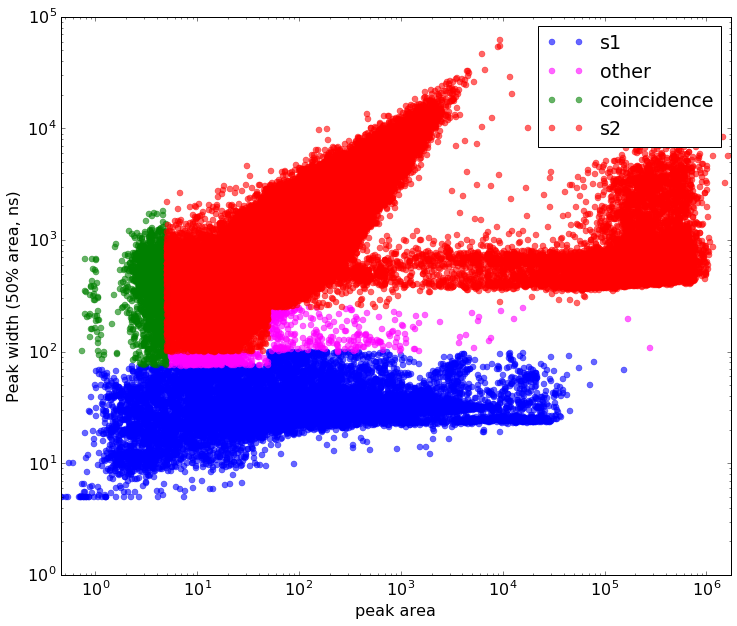

In [4]:
peak_classes = {'s1': s1_class, 's2':s2_class, 'coincidence':coin_class, 'other': other_class}
colors = {'s1': 'blue', 's2':'red', 'coincidence':'green', 'other': 'magenta'}
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for key in peak_classes:
    area=np.array(peak_classes[key])[0:len(peak_classes[key]),0:1]
    width = np.array(peak_classes[key])[0:len(peak_classes[key]),1:2]
    ax.plot(area, width, marker='.', color=colors[key], linestyle='', ms=12, label=key, alpha=0.6)
ax.legend()
plt.xlabel('peak area')
plt.ylabel('Peak width (50% area, ns)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**0, 10**5)
plt.show()

In [5]:
import pickle
with open('peaks_clasification.p', 'wb+') as f:
    pickle.dump(peak_classes, f)


In [6]:
ak = area=np.array(peak_classes['s1'])[0:len(peak_classes['s1']),0:1]
wk= width = np.array(peak_classes['s1'])[0:len(peak_classes['s1']),1:2]
a = np.asarray(pks_areas)
w = np.asarray(pks_widths)

# Clasification

In [7]:
outpath = '/home/mayra/Documents/XENON1T/XeAnalysisScripts/peak_classification/plots/'

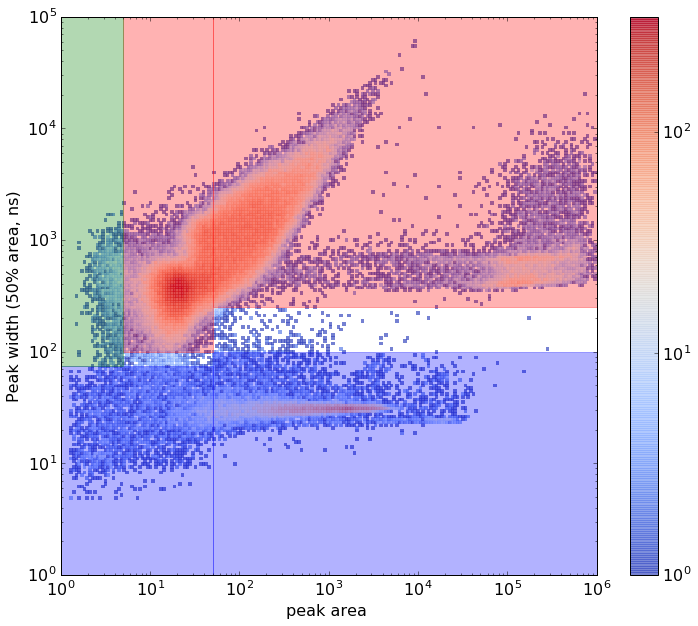

In [8]:

abins =10**np.linspace(0.1, 6, 200)
wbins =10**np.linspace(0,5, 200)
counts, _, _ = np.histogram2d(w, a, bins=(wbins, abins))  
fig, ax = plt.subplots()
cf=ax.pcolormesh(abins, wbins,counts, norm=LogNorm(), alpha=0.7, cmap=cm.coolwarm)
ax.set_xscale('log')
ax.set_yscale('log')
plt.colorbar(cf)
plt.xlabel('peak area ')
plt.ylabel('Peak width (50% area, ns)')
ax = plt.gca()
r = matplotlib.patches.Rectangle((50, 0),10**6.1 ,100 , color='blue', alpha=0.3) 
r2 = matplotlib.patches.Rectangle((50, 250),10**6.1 ,10**5.1 , color='red', alpha=0.3) 
r3 = matplotlib.patches.Rectangle((0, 0),50, 75 , color='blue', alpha=0.3) 
r4 = matplotlib.patches.Rectangle((5, 100),45 ,10**5 , color='red', alpha=0.3)
r5 = matplotlib.patches.Rectangle((0, 75),5,10**5 , color='green', alpha=0.3)
ax.add_artist(r)
ax.add_artist(r2)
ax.add_artist(r3)
ax.add_artist(r4)
ax.add_artist(r5)
plt.savefig(outpath+'peak_classif0_DM.png')
#plt.show()

# Classified by ClassifyPeaks:
# blue = S1, Red= S2, Green = coicidence, other = unknown